### This notebook is divided into 5 main sections : 
- 1- Data Cleaning and feature engineering: we create features from the original data set to test them on clustering 
- 2- Dimensionality reduction : Factor analysis
- 3- Clustering : agglomerative clustering and K prototypes
- 4- Use of clustering on the engineered features 
- 5- Summary and conclusion 

In [128]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import scipy.stats as ss
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
from scipy.cluster.hierarchy import dendrogram, linkage
import gower
from sklearn.cluster import AgglomerativeClustering
from plotly.express import density_heatmap
from sklearn.metrics import silhouette_score
from kmodes.kprototypes import KPrototypes
from sklearn.preprocessing import MinMaxScaler
import prince

In [392]:
def import_data_and_prepare_modeling(path):
    """
    Load dataset given the path 
    cast boolean features 
    keep features for unsupervised learning
    return a pandas dataframe
    """
    df = pd.read_csv(path)
    df["body_camera"] = df["body_camera"].astype(int)
    df["signs_of_mental_illness"] = df["signs_of_mental_illness"].astype(int)
    df_modeling = df[['manner_of_death','age','gender','race','state','flee','signs_of_mental_illness','threat_level','arms_category','body_camera']]
    return df_modeling

def heatmap_Cramer_V(df_cut, figsize=(7, 6)):
    """
    Heatmap for categorical data using Cramer's V 
    df_cut: dataframe containing only categorical features
    figsize: Figure size of the plot, default= (7, 6)
    """

    def cramers_corrected_stat(confusion_matrix):
        chi2 = ss.chi2_contingency(confusion_matrix)[0]
        n = confusion_matrix.sum().sum()
        phi2 = chi2 / n
        r, k = confusion_matrix.shape
        phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
        rcorr = r - ((r - 1) ** 2) / (n - 1)
        kcorr = k - ((k - 1) ** 2) / (n - 1)
        return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

    cols = df_cut.columns.values.tolist()
    corrM = np.zeros((len(cols), len(cols)))
    for col1, col2 in itertools.combinations(cols, 2):
        idx1, idx2 = cols.index(col1), cols.index(col2)
        corrM[idx1, idx2] = cramers_corrected_stat(
            pd.crosstab(df_cut[col1], df_cut[col2])
        )
        corrM[idx2, idx1] = corrM[idx1, idx2]

    corr = pd.DataFrame(corrM, index=cols, columns=cols)
    fig, ax = plt.subplots(figsize=figsize)
    ax = sns.heatmap(corr, annot=True, ax=ax)
    ax.set_title("Cramer V Correlation")

def conditionnal_probability(dataframe, name_column, level, name_column_2):
    """
    Compute the probability : P(name_column_2 | name_column = level )
    
    """
    return pd.DataFrame(dataframe[dataframe[name_column]==level][name_column_2].value_counts()
                        / len(dataframe[dataframe[name_column]==level]))

def print_silhouette_scores_given_methods_and_clusters(matrix, methods=['single','complete','average'], 
                                                       n_clusters=list(range(2,11))):
    """
    """
    max_val=0
    best_method=None
    best_n_clusters=None

    for method in methods:
        for n_cluster in n_clusters:
            c = silhouette_score(matrix,
                             AgglomerativeClustering(n_clusters= n_cluster, affinity="precomputed", linkage=method).fit(matrix).labels_,
                             metric="precomputed")
            if (c>max_val):
                max_val=c
                best_method=method
                best_n_clusters=n_cluster
            else:
                max_val=max_val
            #print ('({} ,{}) : {}'.format(method, n_cluster, c))
    
    print('the best silhouette score is: {} with the following parameters: {}, {}'.format(max_val,best_method,best_n_clusters))
def discretize_age(x):
    """
    Transform the age into an ordinal feature
    """
    if x<12:
        return 0
    elif x<18:
        return 1
    elif x<60:
        return 2
    else:
        return 3
def from_category_to_dangerosity(x):
    if x in ['Guns' ,'Explosives','Vehicles', 'Multiple']:
        return 3
    elif x=="Unknown":
        return 1
    elif x =='Unarmed':
        return 0
    else:
        return 2 
def replace_level_by_frequency(value_counts, x):
    return value_counts[x]/value_counts.sum()
def change_race(x):
    if x not in ['White', 'Hispanic', 'Black']:
        return 'others'
    else:
        return x
def change_threat_level(x):
    if x=='attack':
        return 2
    elif x=='other':
        return 1
    elif x=='undetermined':
        return 0

# 1- Data Cleaning and Feature engineering

In [343]:
df = pd.read_csv("shootings.csv")

### Do we have duplicates rows ?

In [397]:
df.drop_duplicates()

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,arms_category,freq_age,mean_homicide_ratio,dangerosity_arm,threat_level_ordinal
0,3,Tim Elliot,2015-01-02,shot,gun,53.0,M,others,Shelton,WA,True,attack,Not fleeing,False,Guns,0.925941,2.725,3,2
1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,White,Aloha,OR,False,attack,Not fleeing,False,Guns,0.925941,2.250,3,2
2,5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,Hispanic,Wichita,KS,False,other,Not fleeing,False,Unarmed,0.925941,3.750,0,1
3,8,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,M,White,San Francisco,CA,True,attack,Not fleeing,False,Other unusual objects,0.925941,4.550,2,2
4,9,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,M,Hispanic,Evans,CO,False,attack,Not fleeing,False,Piercing objects,0.925941,3.275,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4883,5916,Rayshard Brooks,2020-06-12,shot,Taser,27.0,M,Black,Atlanta,GA,False,attack,Foot,True,Electrical devices,0.925941,6.000,2,2
4884,5925,Caine Van Pelt,2020-06-12,shot,gun,23.0,M,Black,Crown Point,IN,False,attack,Car,False,Guns,0.925941,5.450,3,2
4885,5918,Hannah Fizer,2020-06-13,shot,unarmed,25.0,F,White,Sedalia,MO,False,other,Not fleeing,False,Unarmed,0.925941,8.325,0,1
4886,5921,William Slyter,2020-06-13,shot,gun,22.0,M,White,Kansas City,MO,False,other,Other,False,Guns,0.925941,8.325,3,1


### People with the same age and the same name ? Are they a Zombie ? 

In [234]:
df[['name','age']].value_counts()[df[['name','age']].value_counts() > 1]

name                      age      
TK TK                     37.117931    17
Clayton Andrews           40.000000     2
Timothy Leroy Harrington  58.000000     2
David Tylek Atkinson      24.000000     2
TK TK                     42.000000     2
Roderick McDaniel         33.000000     2
Miguel Mercado Segura     31.000000     2
Benjamin Diaz             22.000000     2
dtype: int64

In [235]:
df[(df['name']=='TK TK') & (df['age']>37)& (df['age']<37.2)]

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,arms_category
1600,1848,TK TK,2016-09-01,shot and Tasered,pipe,37.117931,M,Hispanic,Huntington Park,CA,False,other,Not fleeing,False,Blunt instruments
1959,2278,TK TK,2017-01-31,shot and Tasered,knife,37.117931,M,Black,Hollywood,CA,True,attack,Not fleeing,False,Sharp objects
2220,2573,TK TK,2017-05-11,shot,gun,37.117931,M,Hispanic,Arlington,TX,False,attack,Not fleeing,False,Guns
2252,2606,TK TK,2017-05-24,shot,gun,37.117931,M,Hispanic,Los Angeles,CA,False,attack,Not fleeing,False,Guns
2561,2979,TK TK,2017-09-22,shot,unknown,37.117931,M,White,Denver,CO,False,other,Not fleeing,False,Unknown
2692,3131,TK TK,2017-11-10,shot,unknown,37.117931,M,Black,Hinds County,MS,False,other,Not fleeing,False,Unknown
2704,3143,TK TK,2017-11-15,shot,knife,37.117931,M,Black,Jackson,MS,False,other,Not fleeing,False,Sharp objects
2934,3445,TK TK,2018-02-25,shot,gun,37.117931,M,Hispanic,Los Angeles,CA,False,attack,Not fleeing,False,Guns
3204,3732,TK TK,2018-06-01,shot,knife,37.117931,M,White,Torrance,CA,False,other,Not fleeing,False,Sharp objects
3389,3967,TK TK,2018-08-14,shot,gun and knife,37.117931,M,Hispanic,Fresno,CA,True,attack,Not fleeing,True,Multiple


- it looks like the name TK TK is a generic name for people who haven't been identified , 37.11 seems also a generic age for people whom we didn't know their age when constituting the data base ==> Data imputation using the mean of age


In [239]:
df[(df['age']>37)& (df['age']<37.2)].head(1)

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,arms_category
126,584,Alejandro Salazar,2015-02-20,shot,gun,37.117931,M,Hispanic,Houston,TX,False,attack,Car,False,Guns


let's take Alejandro Salazar as an example: 
- from this article : https://homicide.latimes.com/post/alejandro-salazar/ , we see that Alejandro is 43 years old and it proves our intuition about the data imputation

- let's look at the duplicate instances of the same people : A person can't die twice , so we should remove the duplicate instances, let's just take the example of Benjamin Diaz

In [240]:
df[['name','age']].value_counts()[df[['name','age']].value_counts() > 1]['Benjamin Diaz']

age
22.0    2
dtype: int64

In [242]:
df[df['name']=='Benjamin Diaz']

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,arms_category
4350,5150,Benjamin Diaz,2019-11-01,shot,sharp object,22.0,M,Hispanic,Alamogordo,NM,False,attack,Car,False,Sharp objects
4354,5191,Benjamin Diaz,2019-11-01,shot,box cutter,22.0,M,Hispanic,Alamogordo,NM,False,attack,Not fleeing,False,Sharp objects


- It is obviously the same person but with two different "scenarios": one fleeing with a car and one without fleeing with a car 
- when we see this article : https://eu.alamogordonews.com/story/news/local/community/2019/11/01/new-mexico-police-officer-injured-involved-shooting-near-ruidoso/4122067002/ , we see that he was killed because he has exceeded the limitation speed on a highway , so he was with a car 

- Obviously we can't check the exact age of each victim and the duplicates instances on the dataset for this task , so we will let the age as it is and drop one of the duplicates instances randomly 

- to drop the duplicates we will use the key: name, age, race, city 

In [244]:
df[['name','age','race','city']].value_counts()[df[['name','age','race','city']].value_counts()>1]

name                      age        race      city           
TK TK                     37.117931  Hispanic  Los Angeles        3
Benjamin Diaz             22.000000  Hispanic  Alamogordo         2
Miguel Mercado Segura     31.000000  Hispanic  Fountain Valley    2
Timothy Leroy Harrington  58.000000  White     Polkton            2
Roderick McDaniel         33.000000  Black     Magnolia           2
David Tylek Atkinson      24.000000  Black     Raleigh            2
dtype: int64

In [344]:
df = df.drop_duplicates(['name','age','race','city'],keep= 'last')

In [345]:
df.index = list(range(len(df)))

### Feature Age : Binning + transforming into frequencies 

we will divide the age into intervals :
- 0-12 
- 12-19
- 19-60
- 60-100
#### and after that we will replace them by their frequency 

In [347]:
test = df['age'].apply(lambda x: discretize_age(x))
test2 = test.apply(lambda x: replace_level_by_frequency(test.value_counts(), x))
df['freq_age'] = test2

### Cities ? States ? Which one to choose ? 
A correspondance between state and city , we will choose state in order not to fall in the curse of dimensionality 

- we will replace each state by its mean homocide rate using data from wikipedia https://en.wikipedia.org/wiki/List_of_U.S._states_by_homicide_rate
- mean homicide rate = [ rate(2010) + rate(2014) + rate(2017) + rate(2018)] / 4 

In [348]:
def mean_rate(x):
    return ( x['2018']+x['2017']+x['2014']+x['2010']) / 4

In [297]:
csv_data = pd.read_csv('csvData.csv')

In [336]:
csv_data

,State,Abbrev,Code
0,Alabama,Ala.,AL
1,Alaska,Alaska,AK
2,Arizona,Ariz.,AZ
3,Arkansas,Ark.,AR
4,California,Calif.,CA
5,Colorado,Colo.,CO
6,Connecticut,Conn.,CT
7,Delaware,Del.,DE
8,District of Columbia,D.C.,DC
9,Florida,Fla.,FL


In [299]:
csv_table = pd.read_csv('table-1.csv')

In [306]:
csv_table['mean_homocide_rate'] = csv_table.apply(lambda x: mean_rate(x),axis=1)

In [312]:
merged_data = (pd.merge(csv_table, csv_data, on='State'))

In [316]:
merged_data[['Code','mean_homocide_rate']]

,Code,mean_homocide_rate
0,AL,6.950
1,AK,6.625
2,AZ,5.550
3,AR,6.425
4,CA,4.550
5,CO,3.275
6,CT,2.825
7,DE,5.450
8,FL,5.300
9,GA,6.000


In [350]:
def replace_state_by_homicide_rate(merged_data,x):
    if len(merged_data[merged_data['Code']==x])>0:
        return merged_data[merged_data['Code']==x]['mean_homocide_rate'].values[0]
    else:
        return 0

In [354]:
df['state'][df['city']=='Washington']='WA'

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [355]:
df['mean_homicide_ratio'] = df['state'].apply(lambda x:replace_state_by_homicide_rate(merged_data,x))

### Replace arms category by their dangerosity 
Transforming the categorical feature into an ordinal one ( a gun is more dangerous than a hand tool ...etc)

In [357]:
df['dangerosity_arm'] = df['arms_category'].apply(lambda x: from_category_to_dangerosity(x)) 

### Focus on black people , white people and hispanic , others are set to others ! 

In [372]:
df['race'] = df['race'].apply(lambda x : change_race(x))

### Change the threat level into an ordinal feature 

In [375]:
df['threat_level'].value_counts()

attack          3155
other           1526
undetermined     207
Name: threat_level, dtype: int64

In [380]:
df[df['threat_level'] == 'undetermined']['arms_category'].value_counts()

Unknown                  99
Guns                     48
Unarmed                  39
Sharp objects            12
Other unusual objects     5
Blunt instruments         4
Name: arms_category, dtype: int64

In [381]:
df[df['threat_level'] == 'other']['arms_category'].value_counts()

Guns                     507
Sharp objects            490
Unknown                  181
Unarmed                  176
Blunt instruments         64
Other unusual objects     46
Vehicles                  24
Multiple                  16
Piercing objects          14
Electrical devices         4
Explosives                 3
Hand tools                 1
Name: arms_category, dtype: int64

In [384]:
df[df['threat_level'] == 'undetermined']['manner_of_death'].value_counts()

shot                202
shot and Tasered      5
Name: manner_of_death, dtype: int64

In [385]:
df[df['threat_level'] == 'other']['manner_of_death'].value_counts()

shot                1408
shot and Tasered     118
Name: manner_of_death, dtype: int64

In [386]:
df['manner_of_death'].value_counts()

shot                4640
shot and Tasered     248
Name: manner_of_death, dtype: int64

- It seems that the threat level other seems more dangerous than undertermined , so we will encode that as an ordinal feature :
- 2 : attack 
- 1 : other 
- 0 : undertermined 

In [394]:
df['threat_level_ordinal'] = df['threat_level'].apply(lambda x:change_threat_level(x))

In [399]:
df.columns 

Index(['id', 'name', 'date', 'manner_of_death', 'armed', 'age', 'gender',
       'race', 'city', 'state', 'signs_of_mental_illness', 'threat_level',
       'flee', 'body_camera', 'arms_category', 'freq_age',
       'mean_homicide_ratio', 'dangerosity_arm', 'threat_level_ordinal'],
      dtype='object')

In [400]:
df.to_csv('shootings_engineered_dataset.csv', index = False)

### We have our features : 
- manner of death 
- gender 
- signs of mental illness 
- flee 
- body camera
- frequency of homocids per interval of age
- mean homocide ratio for the state
- dangerosity of the arm 
- the threat level modified ordinally 

# 2- Dimensionality reduction 

PCA is desinged for continuous variables. It tries to preserve variance and the concept of squared deviations breaks down when you have binary variables.
- In our case we will use Factor analysis in order to see the most important factors of our dataset and how the features contribues to these factors 

In [125]:
df_modeling = import_data_and_prepare_modeling("shootings.csv")

In [181]:
from factor_analyzer import FactorAnalyzer

In [200]:
fa = FactorAnalyzer(rotation=None, n_factors=2)
df_one_hot = pd.get_dummies(df_modeling)
fa.fit(df_one_hot)

FactorAnalyzer(bounds=(0.005, 1), impute='median', is_corr_matrix=False,
        method='minres', n_factors=2, rotation=None, rotation_kwargs={},
        use_smc=True)

In [210]:
df_modeling['dangerosity_arm'] = df_modeling['arms_category'].apply(lambda x : from_category_to_dangerosity(x))

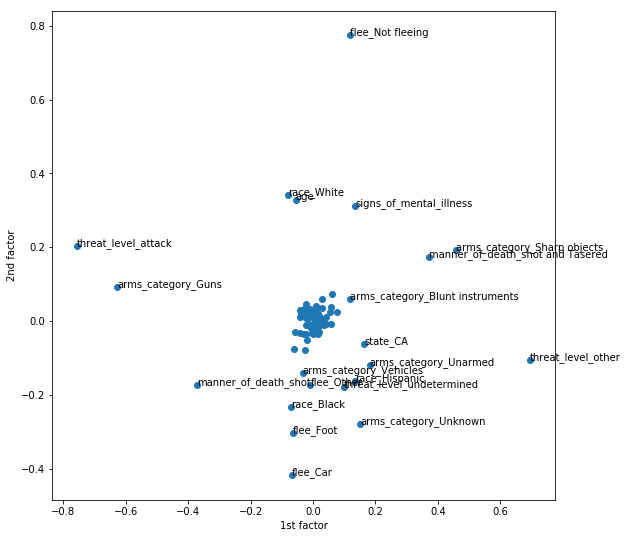

In [214]:
plt.figure(figsize=(9,9))
plt.scatter(fa.loadings_[:,0], fa.loadings_[:,1])
plt.xlabel('1st factor')
plt.ylabel('2nd factor')
"""
plt.xlim(-7, 7)
plt.ylim(-5, 5)
"""
for i in range(fa.loadings_.shape[0]):
    if (abs(fa.loadings_[i,0])>0.1 or abs(fa.loadings_[i,1])>0.1):
        plt.text(fa.loadings_[i,0], fa.loadings_[i,1],df_one_hot.columns[i])



- The first factor looks to be representing the dangerosity of the victim : the lower the factor the more dangerous is the victim ( threat level = attack , arms category = guns ) and the higher the least dangerous : threat level = other 

- the second factor looks to reprensent how resilient the victim is: the higher the factor the more resilient is the victim ( not fleeing ) 
- Another thing interesting about the second factor, we see that black people are opposite to the white people ( they tend to flee, maybe this indicates an ingrained fear and the expectation of violence because of their color) 

In [217]:
for i in range(fa.loadings_.shape[0]):
    if (abs(fa.loadings_[i,0])<0.1 and abs(fa.loadings_[i,1])<0.1):
        print(df_one_hot.columns[i])

body_camera
gender_F
gender_M
race_Asian
race_Native
race_Other
state_AK
state_AL
state_AR
state_AZ
state_CO
state_CT
state_DC
state_DE
state_FL
state_GA
state_HI
state_IA
state_ID
state_IL
state_IN
state_KS
state_KY
state_LA
state_MA
state_MD
state_ME
state_MI
state_MN
state_MO
state_MS
state_MT
state_NC
state_ND
state_NE
state_NH
state_NJ
state_NM
state_NV
state_NY
state_OH
state_OK
state_OR
state_PA
state_RI
state_SC
state_SD
state_TN
state_TX
state_UT
state_VA
state_VT
state_WA
state_WI
state_WV
state_WY
arms_category_Electrical devices
arms_category_Explosives
arms_category_Hand tools
arms_category_Multiple
arms_category_Other unusual objects
arms_category_Piercing objects


# 3- Clustering without feature engineering

In [4]:
df_modeling = import_data_and_prepare_modeling("shootings.csv")

In [5]:
df_modeling

,manner_of_death,age,gender,race,state,flee,signs_of_mental_illness,threat_level,arms_category,body_camera
0,shot,53.0,M,Asian,WA,Not fleeing,1,attack,Guns,0
1,shot,47.0,M,White,OR,Not fleeing,0,attack,Guns,0
2,shot and Tasered,23.0,M,Hispanic,KS,Not fleeing,0,other,Unarmed,0
3,shot,32.0,M,White,CA,Not fleeing,1,attack,Other unusual objects,0
4,shot,39.0,M,Hispanic,CO,Not fleeing,0,attack,Piercing objects,0
...,...,...,...,...,...,...,...,...,...,...
4890,shot,27.0,M,Black,GA,Foot,0,attack,Electrical devices,1
4891,shot,23.0,M,Black,IN,Car,0,attack,Guns,0
4892,shot,25.0,F,White,MO,Not fleeing,0,other,Unarmed,0
4893,shot,22.0,M,White,MO,Other,0,other,Guns,0


- Mixed data : numerical + categorical
- We can't use K Means that uses euclidien distances 
- We need to use a distance that takes into account : continuous features and categorical features 
- ==> Gower distance

## Aglomerative clustering with Gower distance 
let's choose for a first attempt a number of clusters equal to 4

In [7]:
matrix = gower.gower_matrix(df_modeling)

Text(0.5,1,'Histogram for the clusters using an Aglomerative Clustering of 4 clusters')

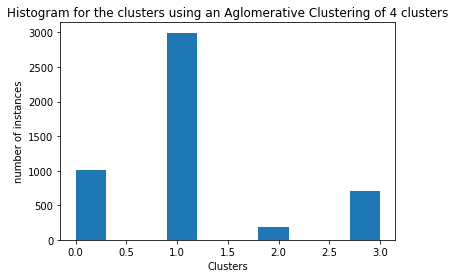

In [27]:
clustering = AgglomerativeClustering(n_clusters= 4, affinity="precomputed", linkage="complete").fit(matrix)
df_clustered = pd.concat([df_modeling,pd.DataFrame(clustering.labels_, columns= ['cluster'] ) ],1)
plt.hist(df_clustered['cluster'])
plt.xlabel("Clusters")
plt.ylabel("number of instances")
plt.title("Histogram for the clusters using an Aglomerative Clustering of 4 clusters")

- A majoritary cluster 1 , the cluster 2 have a lower number of instances compared to the others, let's what are the other differences

Text(0.5,1,'Box plot for the age according to the clusters')

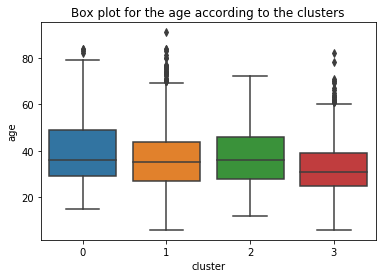

In [28]:
sns.boxplot(data = df_clustered, x='cluster', y='age')
plt.title("Box plot for the age according to the clusters")

- We don't see a big difference in the age statistics, let's plot the density 

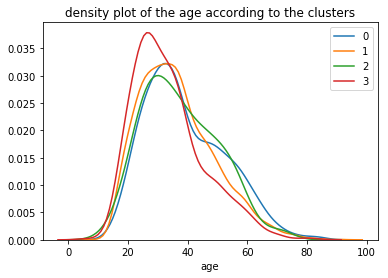

In [29]:
sns.distplot(df_clustered['age'][df_clustered['cluster']==0], hist=False, label = '0')
sns.distplot(df_clustered['age'][df_clustered['cluster']==1], hist=False, label ='1')
sns.distplot(df_clustered['age'][df_clustered['cluster']==2], hist=False, label = '2')
sns.distplot(df_clustered['age'][df_clustered['cluster']==3], hist=False, label = '3')
plt.title("density plot of the age according to the clusters")
plt.show()

- Not a big difference, let's see for the categorical features

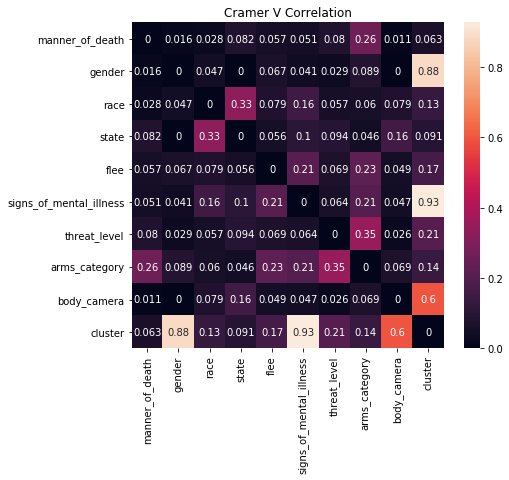

In [12]:
heatmap_Cramer_V(df_clustered.drop(['age'],1), figsize=(7, 6))

- Strong correlation between the clusters and : the gender, the signs of mental illness and the body camera, let's plot their crosstab

In [17]:
print(pd.crosstab(df_clustered['cluster'],df_clustered['gender']),"\n",
      pd.crosstab(df_clustered['cluster'],df_clustered['signs_of_mental_illness']),"\n",
      pd.crosstab(df_clustered['cluster'],df_clustered['body_camera']))

gender     F     M
cluster           
0          9  1000
1         23  2973
2        181     6
3          9   694 
 signs_of_mental_illness     0    1
cluster                           
0                          24  985
1                        2968   28
2                         127   60
3                         673   30 
 body_camera     0    1
cluster               
0             862  147
1            2978   18
2             174   13
3             303  400


- Gender : when the cluster = 2 , A high number of females 
- Signs of mental illness : the cluster 1 seems to gather non mentaly ill people, whereas the cluster 0 seems to gather mentally ill people 
- let's calculate conditional probabilities of a cluster given the gender or the sign of mental illness 

### Probability P(cluster | gender = Female )

In [21]:
conditionnal_probability(df_clustered, "gender", "F", "cluster")

,cluster
2,0.815315
1,0.103604
3,0.040541
0,0.040541


- We see that the probability to belong to the second cluster exceeds 0.8 when the victim is a woman

### Probability P(cluster| sign of mental illness =0)

In [23]:
conditionnal_probability(df_clustered, "signs_of_mental_illness", 0, "cluster")

,cluster
1,0.782700
3,0.177479
2,0.033492
0,0.006329


- a probability of 0.78 to be in cluster 1 

### Probability P(cluster| sign of mental illness = 1)

In [24]:
conditionnal_probability(df_clustered, "signs_of_mental_illness", 1, "cluster")

,cluster
0,0.893019
2,0.054397
3,0.027199
1,0.025385


- a probability of 0.89 to belong to the cluster 0

- Let's see other hyper-parameters of the model 

In [35]:
print_silhouette_scores_given_methods_and_clusters(matrix)

the best silhouette score is: 0.32917872071266174 with the following parameters: single, 2


Text(0.5,1,'Histogram for the clusters using an Aglomerative Clustering of 4 clusters')

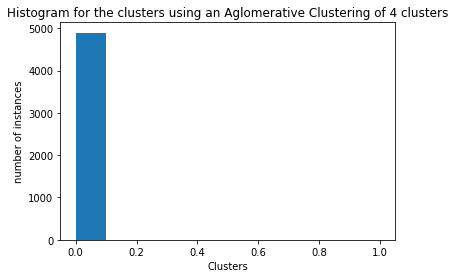

In [36]:
clustering = AgglomerativeClustering(n_clusters= 2, affinity="precomputed", linkage="single").fit(matrix)
df_clustered = pd.concat([df_modeling,pd.DataFrame(clustering.labels_, columns= ['cluster'] ) ],1)
plt.hist(df_clustered['cluster'])
plt.xlabel("Clusters")
plt.ylabel("number of instances")
plt.title("Histogram for the clusters using an Aglomerative Clustering of 4 clusters")

- When the clustering doesn't give balanced clusters, the silhouette score isn't informative ( it will advantage to high unbalanced clusters like in this case)

## Aglomerative clustering with Manhattan distance ( and only discrete features)

In [38]:
df_modeling

,manner_of_death,age,gender,race,state,flee,signs_of_mental_illness,threat_level,arms_category,body_camera
0,shot,53.0,M,Asian,WA,Not fleeing,1,attack,Guns,0
1,shot,47.0,M,White,OR,Not fleeing,0,attack,Guns,0
2,shot and Tasered,23.0,M,Hispanic,KS,Not fleeing,0,other,Unarmed,0
3,shot,32.0,M,White,CA,Not fleeing,1,attack,Other unusual objects,0
4,shot,39.0,M,Hispanic,CO,Not fleeing,0,attack,Piercing objects,0
...,...,...,...,...,...,...,...,...,...,...
4890,shot,27.0,M,Black,GA,Foot,0,attack,Electrical devices,1
4891,shot,23.0,M,Black,IN,Car,0,attack,Guns,0
4892,shot,25.0,F,White,MO,Not fleeing,0,other,Unarmed,0
4893,shot,22.0,M,White,MO,Other,0,other,Guns,0


- discretize the age into 4 categories : kids, teenagers, adults, elderly ==> Ordinal feature
- One hot the other features because they aren't ordinal 

In [51]:
df_modeling['discrete_age']=df['age'].apply(lambda x:discretize_age(x))
df_modeling_one_hot = pd.get_dummies(df_modeling.drop(['age'],1), drop_first= True)

Text(0.5,1,'Histogram for the clusters using an Aglomerative Clustering of 4 clusters and manhattan distance')

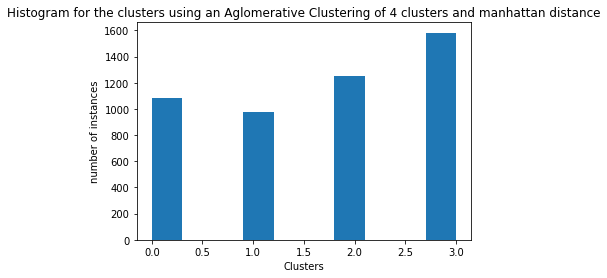

In [52]:
clusterer = AgglomerativeClustering(n_clusters=4, affinity='manhattan', linkage='complete').fit(df_modeling_one_hot)
df_clustered = pd.concat([df_modeling,pd.DataFrame(clusterer.labels_, columns= ['cluster'] ) ],1)
plt.hist(df_clustered['cluster'])
plt.xlabel("Clusters")
plt.ylabel("number of instances")
plt.title("Histogram for the clusters using an Aglomerative Clustering of 4 clusters and manhattan distance")

- A better distributed Clustering

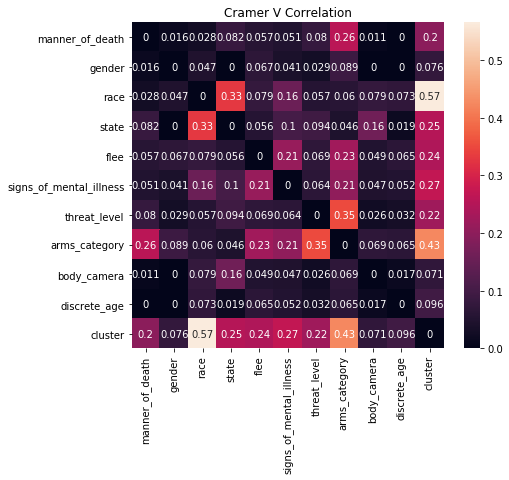

In [54]:
heatmap_Cramer_V(df_clustered.drop(['age'],1), figsize=(7, 6))

- Something Interesting, the clusters are correlated with the race and the arms_category !

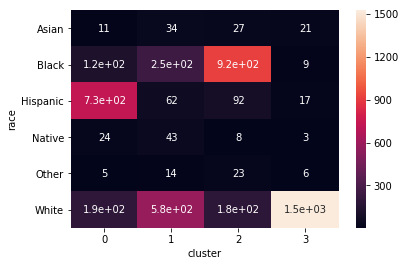

In [57]:
sns.heatmap(pd.crosstab(df_clustered['race'], df_clustered['cluster']), annot=True)

- Most of the black people are in the cluster 2 whereas most of the white people are in the cluster 3, the hispanic meanwhile tend to be in the cluster 0

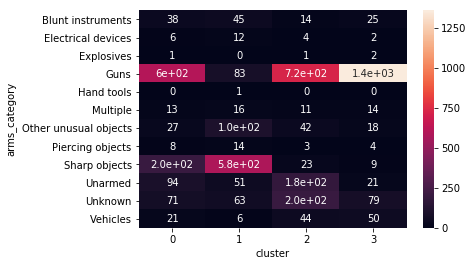

In [58]:
sns.heatmap(pd.crosstab(df_clustered['arms_category'], df_clustered['cluster']), annot=True)

- Cluster 1 is well known for sharp objects and not guns haha, whereas the cluster 3 is known for guns 

cluster 3 : white and guns? let's see the probability of the race given the arms category = guns

In [59]:
conditionnal_probability(df_clustered, "arms_category","Guns", "race")

,race
White,0.526411
Black,0.277135
Hispanic,0.162084
Native,0.014834
Asian,0.012663
Other,0.006874


## Why not transforming the categorical data into numerical one and do a K-means after that ? 
In the case we have a strong discriminative continuous feature towards some categorical data, we can replace these categorical features by some statistics of the discriminative feature ( just like mean encoding in classification) 
let's see if the age is a discriminative feature towards the categorical data

  adjustable: [ 'box' | 'datalim']
  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array 
  alpha: float (0.0 transparent through 1.0 opaque) 
  anchor: [ 'C' | 'SW' | 'S' | 'SE' | 'E' | 'NE' | 'N' | 'NW' | 'W' ]
  animated: bool 
  aspect: unknown
  autoscale_on: bool
  autoscalex_on: bool
  autoscaley_on: bool
  axes_locator: a callable object which takes an axes instance and renderer and returns a bbox.
  axisbelow: [ bool | 'line' ]
  clip_box: a `.Bbox` instance 
  clip_on: bool 
  clip_path: [(`~matplotlib.path.Path`, `.Transform`) | `.Patch` | None] 
  contains: a callable function 
  facecolor: color
  fc: color
  figure: `.Figure`
  frame_on: bool
  gid: an id string 
  label: object 
  navigate: bool
  navigate_mode: unknown
  path_effects: `.AbstractPathEffect` 
  picker: [None | bool | float | callable] 
  position: unknown
  rasterization_zorder: float or None 
  rasterized: bool or None 
  sketch_params: (scale

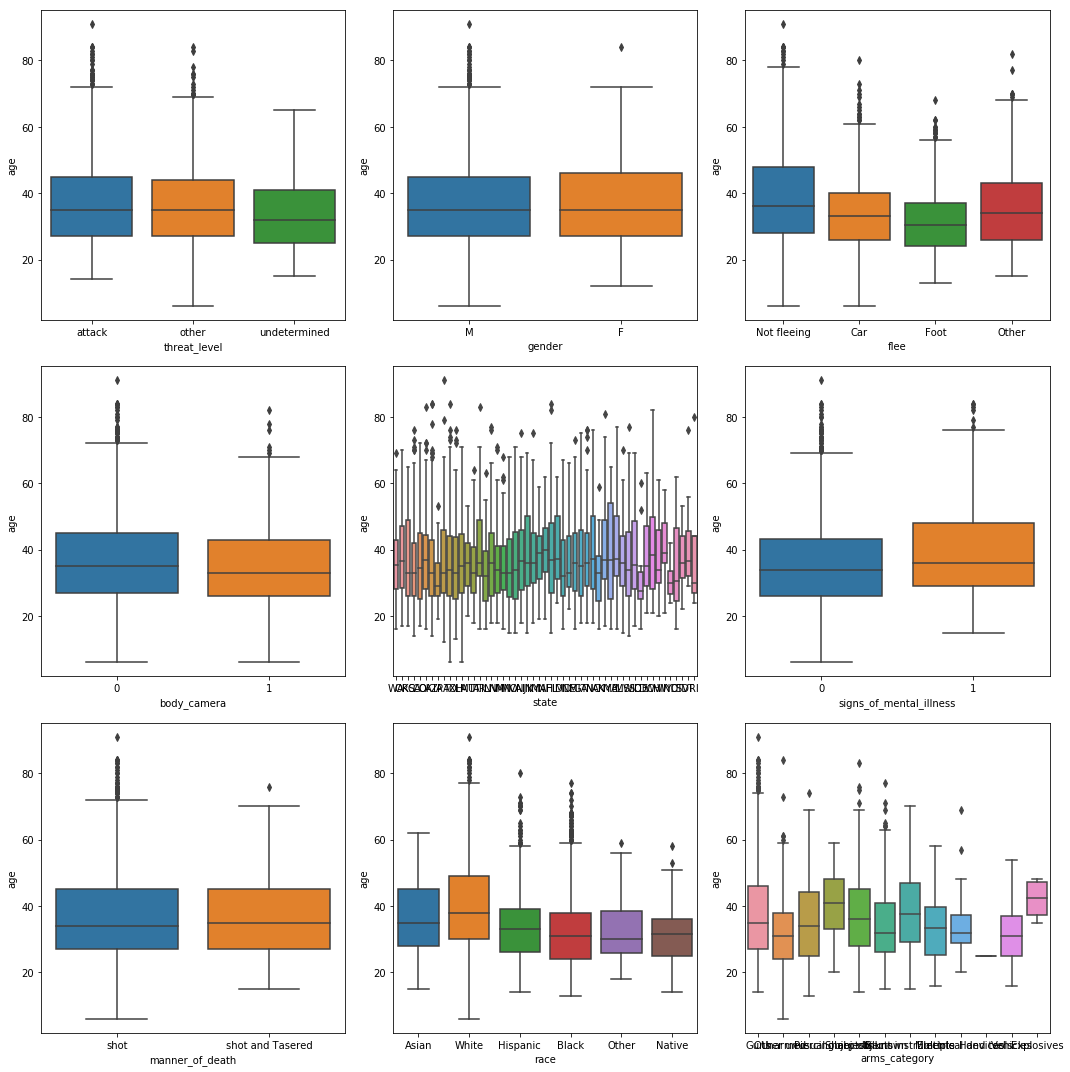

In [79]:
f, axes = plt.subplots(3, 3, figsize=(15,15))
axes = axes.ravel()
for index,column in enumerate(list(set(df_modeling.columns)-set(['age','discrete_age']))):
    sns.boxplot(data = df_modeling, x=column, y="age", ax=axes[index])

plt.setp(axes)
plt.tight_layout()

- The age doesn't seem discriminative enough to do an encoding with it

## A model Adapted for Mixed data and with the same idea as K means:  Clustering large data sets with mixed numeric and categorical values ==> K prototypes (K means + K modes )

- Let's try 4 clusters

Text(0.5,1,'Histogram for the clusters using the K propotypes with 4 clusters')

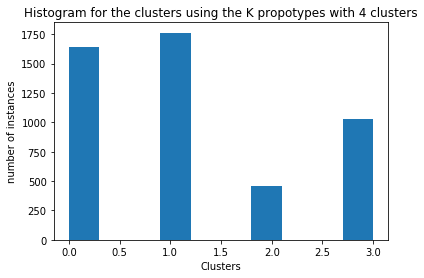

In [82]:
kp = KPrototypes(n_clusters=4)
kp.fit(df_modeling.drop(['discrete_age'],1), categorical=[0,2,3,4,5,6,7,8,9])
clusters = kp.labels_
df_clustered = pd.concat([df_modeling,pd.DataFrame(kp.labels_, columns= ['cluster'] ) ],1)
plt.hist(df_clustered['cluster'])
plt.xlabel("Clusters")
plt.ylabel("number of instances")
plt.title("Histogram for the clusters using the K propotypes with 4 clusters")

Text(0.5,1,'Elbow method with K prototypes')

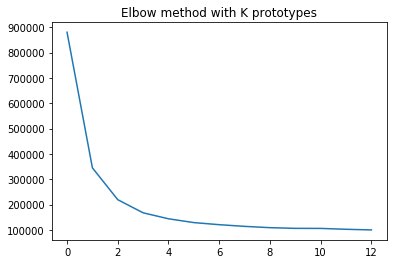

In [90]:
cost = []
for num_clusters in list(range(1,14)):
    kproto = KPrototypes(n_clusters=num_clusters)
    kproto.fit(df_modeling.drop(['discrete_age'],1), categorical=[0,2,3,4,5,6,7,8,9])
    cost.append(kproto.cost_)
    
plt.plot(cost)
plt.title('Elbow method with K prototypes')

- number of clusters : 2 

Text(0.5,1,'Histogram for the clusters using the K propotypes with 4 clusters')

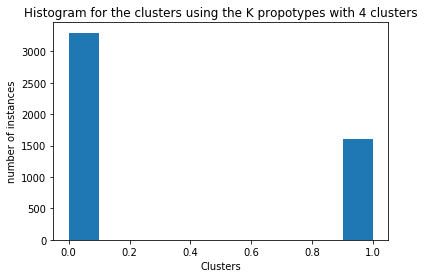

In [92]:
kp = KPrototypes(n_clusters=2)
kp.fit(df_modeling.drop(['discrete_age'],1), categorical=[0,2,3,4,5,6,7,8,9])
clusters = kp.labels_
df_clustered = pd.concat([df_modeling,pd.DataFrame(kp.labels_, columns= ['cluster'] ) ],1)
plt.hist(df_clustered['cluster'])
plt.xlabel("Clusters")
plt.ylabel("number of instances")
plt.title("Histogram for the clusters using the K propotypes with 4 clusters")

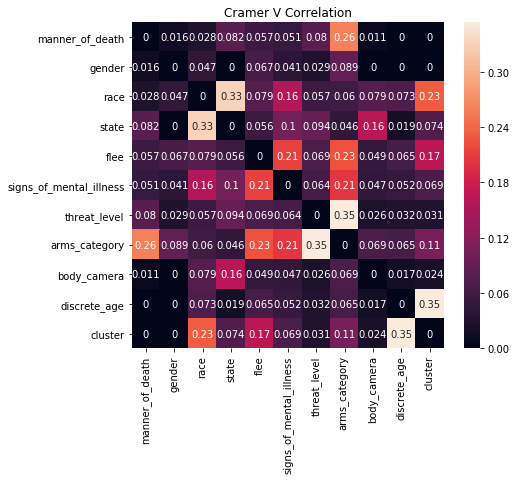

In [93]:
heatmap_Cramer_V(df_clustered.drop(['age'],1), figsize=(7, 6))

- race and age seem to be correlated

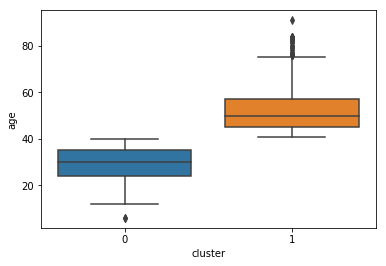

In [95]:
sns.boxplot(data=df_clustered, x="cluster", y="age")

In [100]:
print(df_clustered[df_clustered["cluster"]==0]["age"].max(),'vs',df_clustered[df_clustered["cluster"]==1]["age"].min())

40.0 vs 41.0


#### the age is the only discriminative feature ==> we need to scale in order to give it the same importance as the other features 

In [103]:
df_scaled = pd.concat([
    df_modeling,
    pd.DataFrame(MinMaxScaler().fit_transform(np.array( df_modeling['age']).reshape(-1, 1)),columns=["scaled_age"])],1)

Text(0.5,1,'Histogram for the clusters using the K propotypes with 4 clusters')

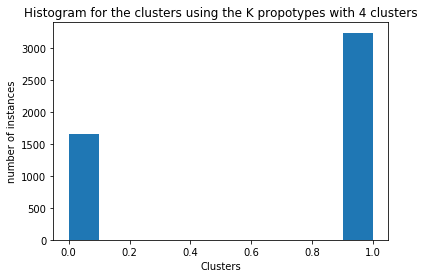

In [105]:
kp = KPrototypes(n_clusters=2)
kp.fit(df_scaled.drop(["age","discrete_age"],1), categorical=[0,1,2,3,4,5,6,7,8])
clusters = kp.labels_
df_clustered = pd.concat([df_scaled,pd.DataFrame(kp.labels_, columns= ['cluster'] ) ],1)
plt.hist(df_clustered['cluster'])
plt.xlabel("Clusters")
plt.ylabel("number of instances")
plt.title("Histogram for the clusters using the K propotypes with 4 clusters")

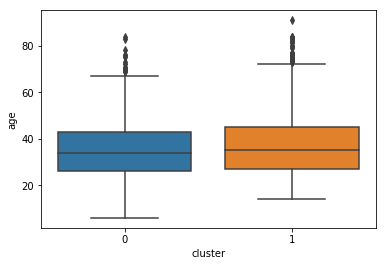

In [106]:
sns.boxplot(data=df_clustered, x="cluster", y="age")

- The age doesn't seem so discriminative now 

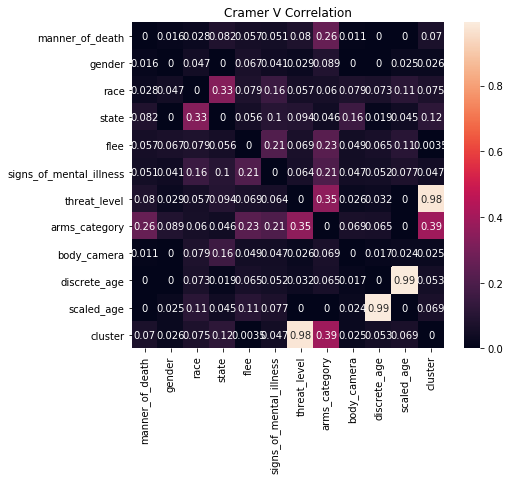

In [107]:
heatmap_Cramer_V(df_clustered.drop(['age'],1), figsize=(7, 6))

- A very strong correlation with the threat_level and a medium one with arms_category 

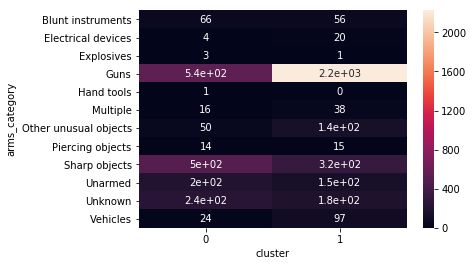

In [108]:
sns.heatmap(pd.crosstab(df_clustered['arms_category'], df_clustered['cluster']), annot=True)

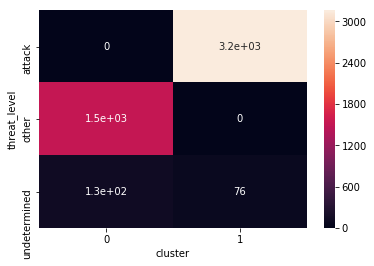

In [109]:
sns.heatmap(pd.crosstab(df_clustered['threat_level'], df_clustered['cluster']), annot=True)

- Looks like the cluster 1 concerns the people who are a bit "responsible" ( armed + attack) for the death ( even if nothing justifies a death...)
whereas cluster 0 concerns more people who don't show resistance ( maybe stray bullets ? ) 

# 4- Clustering with feature engineering 

In [423]:
df = pd.read_csv('shootings_engineered_dataset.csv')

In [424]:
df = df.drop(['id', 'name', 'date', 'armed', 'age', 'city', 'state', 'threat_level', 'arms_category'],1)
df["body_camera"] = df["body_camera"].astype(object)
df["signs_of_mental_illness"] = df["signs_of_mental_illness"].astype(object)

Text(0.5,1,'Elbow method with K prototypes')

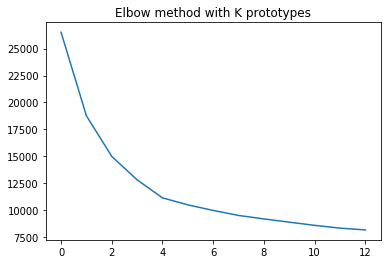

In [430]:
cost = []
for num_clusters in list(range(1,14)):
    kproto = KPrototypes(n_clusters=num_clusters)
    kproto.fit(df, categorical=[0,1,2,3,4,5])
    cost.append(kproto.cost_)
    
plt.plot(cost)
plt.title('Elbow method with K prototypes')

Text(0.5,1,'Histogram for the clusters using the K propotypes with 4 clusters')

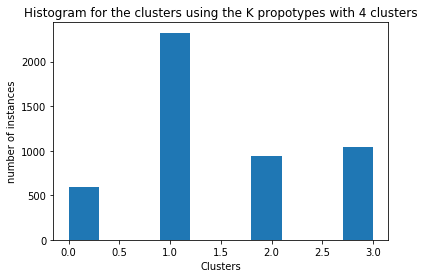

In [431]:
kp = KPrototypes(n_clusters=4)
kp.fit(df, categorical=[0,1,2,3,4,5])
clusters = kp.labels_
df_clustered = pd.concat([df,pd.DataFrame(kp.labels_, columns= ['cluster'] ) ],1)
plt.hist(df_clustered['cluster'])
plt.xlabel("Clusters")
plt.ylabel("number of instances")
plt.title("Histogram for the clusters using the K propotypes with 4 clusters")

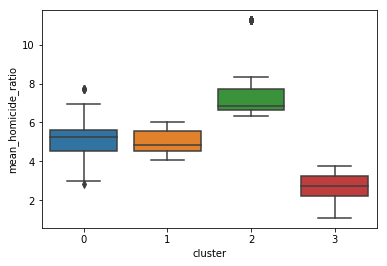

In [434]:
sns.boxplot(data=df_clustered, x="cluster", y="mean_homicide_ratio")

- it looks like the cluster 2 gathers states with a high homicide ratio wheras cluster 3 gathers states with a low homicide ratio
- for cluster 0 and 1 there is no big difference , let's see other features

In [432]:
df.columns

Index(['manner_of_death', 'gender', 'race', 'signs_of_mental_illness', 'flee',
       'body_camera', 'freq_age', 'mean_homicide_ratio', 'dangerosity_arm',
       'threat_level_ordinal'],
      dtype='object')

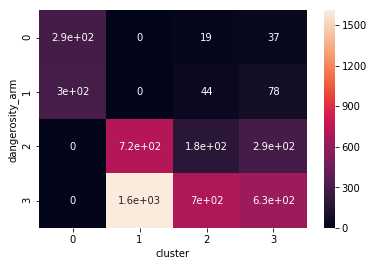

In [435]:
sns.heatmap(pd.crosstab(df_clustered['dangerosity_arm'], df_clustered['cluster']), annot=True)

- Here we see the difference between cluster 0 and cluster 1 
- cluster 1 gathers dangerous arms ( type 2 and 3 ) whereas cluster 0 gathers less dangerous ones ( type 1 and 0)

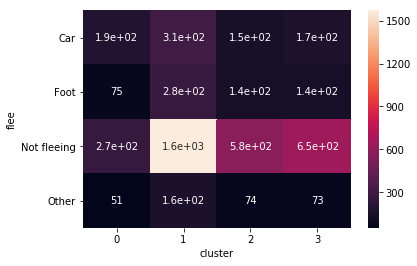

In [439]:
sns.heatmap(pd.crosstab(df_clustered['flee'], df_clustered['cluster']), annot=True)

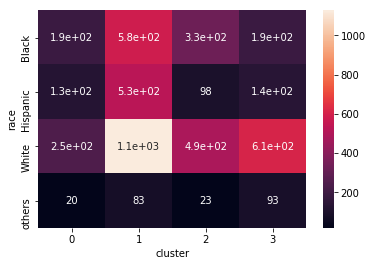

In [440]:
sns.heatmap(pd.crosstab(df_clustered['race'], df_clustered['cluster']), annot=True)

- Furthermore, in cluster 1 we see that there are a lot of black people and a lot of fleeing people whereas in cluster 3 , a lot of white people and not fleeing people

Other observations can be done ...

# 5- To summarize 
We have tested several modeling approaches : 
- Factor analysis
- Aglomerative clustering with Gower distance because of the mixed data 
- Aglomerative clustering with manhattan distance by binning the feature age
- The possibilty of transforming the categorical data into numerical ones ( like mean encoding for classification)
- K prototypes by choosing the best k using the elbow method 
- Interpretation of each clustering by looking at some patterns/ statistics for the clusters 


Moreover we have created another data set by doing some feature engineering in order for our features to be more suitable for the clustering and tested K prototypes on it 

Other feature engineering steps can be done to improve the modeling like for example using web scarping to collect articles about the victim and look for keywords, or see if the victim has a past in prison ..etc , but everything will depend on the theme of the clustering !